### Word2vec embedding

In [ ]:
# tokenizing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

word_tokens = []
for sentence in list(data.text):
  word_tokens.append(word_tokenize(str(sentence)))

# stopwords
stop_words = set(stopwords.words('english'))

result = []

for word in word_tokens:
  temp = []

  for i in range(len(word)):
    if len(word[i]) > 2:
      if word[i] not in stop_words:
        temp.append(word[i])

  result.append(temp)

result = list(filter(None, result))

In [ ]:
# word2vec
from gensim.models.word2vec import Word2Vec

model = Word2Vec(result,        
                 sg=1,         
                 size=100,     
                 window=3,    
                 min_count=2,
                 workers=4,
                 iter=5)

In [ ]:
#model.save('word2vec.model')

In [29]:
from gensim.models import Word2Vec
model = Word2Vec.load('/content/drive/MyDrive/컨퍼런스/word2vec.model')
print(model.wv.most_similar("love", topn=5))
print(model.wv.most_similar("sad", topn=5))
print(model.wv.most_similar("girl", topn=5))

[('loves', 0.7376604080200195), ('loving', 0.6941666603088379), ('hate', 0.6874850988388062), ('luv', 0.6819210648536682), ('awesome', 0.6746213436126709)]
[('heartbroken', 0.8496648073196411), ('disappointed', 0.8112217783927917), ('fed', 0.794059157371521), ('upset', 0.7872953414916992), ('melancholy', 0.7856727838516235)]
[('boy', 0.8734229803085327), ('puppy', 0.8205183744430542), ('lady', 0.811775803565979), ('girls', 0.8107936382293701), ('sister', 0.8044112920761108)]


### LSTM model

In [ ]:
# import packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [22]:
# data load
data = pd.read_csv("/content/drive/MyDrive/컨퍼런스/result.csv")
data.text = data.text.astype(str)
data.head()

,text,anger,disgust,fear,joy,sadness,surprise,no emotion
0,The kitchen stinks .,0,1,0,0,0,0,0
1,I'll throw out the garbage .,0,0,0,0,0,0,1
2,"So Dick , how about getting some coffee for to...",0,0,0,1,0,0,0
3,Coffee ? I don ’ t honestly like that kind of ...,0,1,0,0,0,0,0
4,"Come on , you can at least try a little , besi...",0,0,0,0,0,0,1


In [23]:
# text preprocessing
data['text'] = data['text'].apply(lambda x: x.lower()) # 소문자로
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) # 영문자 이외 문자 제거

word_tokens = []
for sentence in list(data.text):
  word_tokens.append(word_tokenize(str(sentence)))

stop_words = set(stopwords.words('english'))

result = []

for word in word_tokens:
  temp = []

  for i in range(len(word)):
    if len(word[i]) > 2: # 길이가 2 이하인 단어 제거
      if word[i] not in stop_words: # 불용어 제거
        temp.append(word[i])

  result.append(temp)

data['text'] = pd.Series(result).apply(lambda x: ' '.join(x))
data.drop(data[data['text'] == 'nan'].index, inplace=True) # nan 제거

In [24]:
# train, test split
Y = data.copy().drop(columns='text').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(data['text'], Y, test_size=0.2, shuffle=True, random_state=200)

In [25]:
# preprocessing
token = Tokenizer()
token.fit_on_texts(list(X_train) + list(X_test))

X_train_pad = pad_sequences(token.texts_to_sequences(X_train), padding='pre', maxlen=200)
X_test_pad = pad_sequences(token.texts_to_sequences(X_test), padding='pre', maxlen=200)

In [30]:
# Word2vec embedding
vocab_size = len(token.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

def get_vector(word):
    if word in model:
        return model[word]
    else:
        return None

for word, i in token.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [ ]:
print(model['nice'])

In [ ]:
print(embedding_matrix[token.word_index['nice']])

In [ ]:
# LSTM modeling
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False))
model.add(LSTM(100, dropout=0.2, return_sequences=True))
model.add(LSTM(50, dropout=0.3))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 100)          5205500   
_________________________________________________________________
lstm_18 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 357       
Total params: 5,316,457
Trainable params: 110,957
Non-trainable params: 5,205,500
_________________________________________________________________
None


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=64, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
2262/2262 [==============================] - 53s 23ms/step - loss: 1.0537 - accuracy: 0.6468 - val_loss: 0.9819 - val_accuracy: 0.6752
Epoch 2/200
2262/2262 [==============================] - 50s 22ms/step - loss: 0.9675 - accuracy: 0.6764 - val_loss: 0.9287 - val_accuracy: 0.6907
Epoch 3/200
2262/2262 [==============================] - 50s 22ms/step - loss: 0.9275 - accuracy: 0.6935 - val_loss: 0.8880 - val_accuracy: 0.7077
Epoch 4/200
2262/2262 [==============================] - 51s 23ms/step - loss: 0.9044 - accuracy: 0.7015 - val_loss: 0.8702 - val_accuracy: 0.7174
Epoch 5/200
2262/2262 [==============================] - 52s 23ms/step - loss: 0.8837 - accuracy: 0.7109 - val_loss: 0.8587 - val_accuracy: 0.7242
Epoch 6/200
2262/2262 [==============================] - 50s 22ms/step - loss: 0.8700 - accuracy: 0.7154 - val_loss: 0.8352 - val_accuracy: 0.7309
Epoch 7/200
2262/2262 [==============================] - 50s 22ms/step - loss: 0.8599 - accuracy: 0.7186 - val_loss: 0

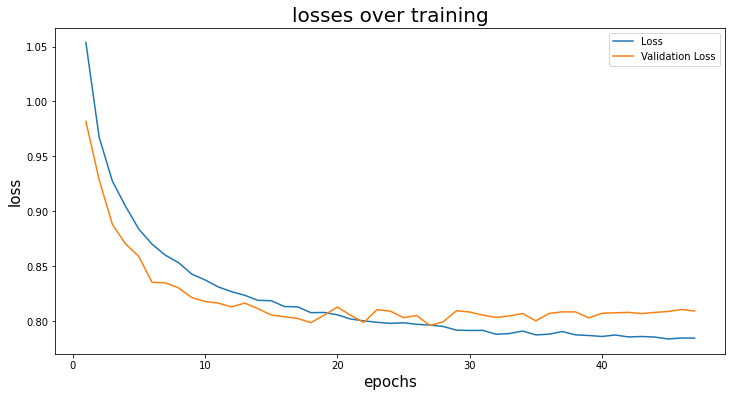

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(47)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(47)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

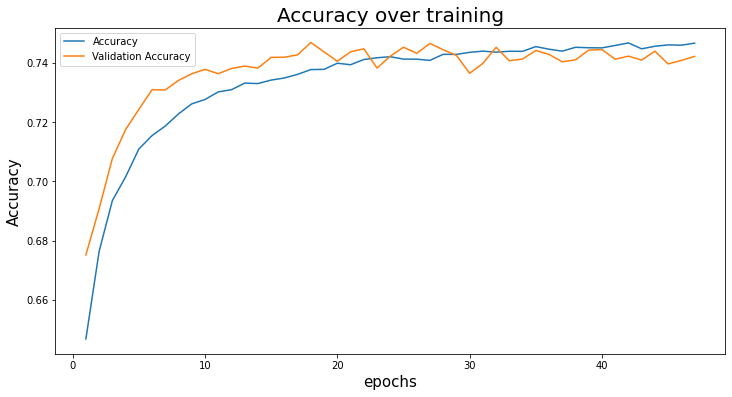

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(47)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(47)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()

In [31]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/컨퍼런스/model.h5")
#model.save("model.h5")

In [32]:
# predict
emotion = model.predict(X_test_pad)
emo = np.round(emotion)

sent_to_emotion = {0:'anger', 1:'disgust', 2:'fear', 3:'joy', 4:'sadness', 5:'surprise', 6:'no emotion'}

x = []
for i in range(len(emo)):
    x.append(np.argmax(emo[i]))

actual = []
for i in range(len(y_test)):
    actual.append(np.argmax(y_test[i]))

In [34]:
result_data = pd.DataFrame({"Text": data_copy.iloc[X_test.index]['text'].reset_index(drop=True), "Actual": pd.Series(actual).map(sent_to_emotion),
                            "Predict": pd.Series(x).map(sent_to_emotion)})
result_data.head(20)

,Text,Actual,Predict
0,i woke up feeling fabulous and im sure that ha...,joy,joy
1,"Yes . I did some work on that , and I found ou...",no emotion,no emotion
2,Driving home after an ok night Iwish,no emotion,anger
3,i first held my scotty i knew i was in love wi...,fear,fear
4,well I learnt to use a machine yesterday! not ...,no emotion,no emotion
5,Good . Friday morning at 9 .,no emotion,no emotion
6,hi name !,no emotion,no emotion
7,i had picked oxbow in the kentucky derby two w...,sadness,sadness
8,I am worrying about my husband .,no emotion,no emotion
9,family comes. probably won't be on this weekend,sadness,no emotion


In [35]:
n = 0
for i in range(len(result_data)):
  if result_data['Actual'][i] == result_data['Predict'][i]:
    n += 1

print((n / len(result_data)) * 100)

70.05196241017137


In [39]:
# input textt
text = []
text.append(str(input("텍스트를 영어로 입력하세요: ")))
token.fit_on_texts(text)
text_pre = pad_sequences(token.texts_to_sequences(text), padding='pre', maxlen=200)
pre = model.predict(text_pre)
print("해당 텍스트의 감정은 " + pd.Series(np.argmax(np.round(pre))).map(sent_to_emotion) + " 입니다.")

텍스트를 영어로 입력하세요: I love you
0    해당 텍스트의 감정은 joy 입니다.
dtype: object
